# FightPredict - Exploratory Data Analysis

**UFC Fight Outcome Prediction**

This notebook explores the UFC dataset to understand patterns, relationships, and insights before model training.

---

## Contents

1. [Data Overview](#1-data-overview)
2. [Target Variable Analysis](#2-target-variable-analysis)
3. [Physical Attributes](#3-physical-attributes)
4. [Career Statistics](#4-career-statistics)
5. [Fighting Style Analysis](#5-fighting-style-analysis)
6. [Momentum & Streaks](#6-momentum--streaks)
7. [Betting Odds Analysis](#7-betting-odds-analysis)
8. [Feature Correlations](#8-feature-correlations)
9. [Key Insights Summary](#9-key-insights-summary)

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.3f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Figure defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✓ Libraries loaded")

✓ Libraries loaded


In [2]:
# Load data
DATA_PATH = Path("../data/processed")

# Load engineered features
df = pd.read_csv(DATA_PATH / "features_engineered.csv", parse_dates=['event_date'])

# Load model-ready data
df_model = pd.read_csv(DATA_PATH / "features_model_ready.csv")
df_model_odds = pd.read_csv(DATA_PATH / "features_model_ready_with_odds.csv")

# Load fighters
fighters = pd.read_csv(DATA_PATH / "fighters.csv")

print(f"Fights dataset: {len(df):,} rows, {len(df.columns)} columns")
print(f"Model-ready (no odds): {len(df_model):,} rows, {len(df_model.columns)} columns")
print(f"Model-ready (with odds): {len(df_model_odds):,} rows, {len(df_model_odds.columns)} columns")
print(f"Fighters: {len(fighters):,} unique fighters")

Fights dataset: 8,230 rows, 498 columns
Model-ready (no odds): 8,230 rows, 102 columns
Model-ready (with odds): 8,230 rows, 111 columns
Fighters: 2,615 unique fighters


---
## 1. Data Overview

In [3]:
# Basic info
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nTotal fights: {len(df):,}")
print(f"Date range: {df['event_date'].min().date()} to {df['event_date'].max().date()}")
print(f"Total years: {(df['event_date'].max() - df['event_date'].min()).days / 365:.1f} years")
print(f"\nUnique fighters: {len(set(df['f_1_name'].unique()) | set(df['f_2_name'].unique())):,}")
print(f"Weight classes: {df['weight_class'].nunique()}")
print(f"Title fights: {df['title_fight'].sum():,} ({df['title_fight'].mean()*100:.1f}%)")

DATASET OVERVIEW

Total fights: 8,230
Date range: 1994-03-11 to 2025-10-04
Total years: 31.6 years

Unique fighters: 2,615
Weight classes: 21
Title fights: 443 (5.4%)


In [4]:
# Sample of the data
print("\nSample fights:")
df[['event_date', 'f_1_name', 'f_2_name', 'winner', 'result', 'weight_class']].head(10)


Sample fights:


,event_date,f_1_name,f_2_name,winner,result,weight_class
0,1994-03-11,Scott Morris,Sean Daugherty,Scott Morris,Submission,Open Weight
1,1994-03-11,Patrick Smith,Scott Morris,Patrick Smith,KO/TKO,Open Weight
2,1994-03-11,Royce Gracie,Patrick Smith,Royce Gracie,KO/TKO,UFC 2 Tournament Title
3,1994-03-11,Johnny Rhodes,David Levicki,Johnny Rhodes,KO/TKO,Open Weight
4,1994-03-11,Orlando Wiet,Robert Lucarelli,Orlando Wiet,KO/TKO,Open Weight
5,1994-03-11,Remco Pardoel,Orlando Wiet,Remco Pardoel,KO/TKO,Open Weight
6,1994-03-11,Frank Hamaker,Thaddeus Luster,Frank Hamaker,Submission,Open Weight
7,1994-03-11,Remco Pardoel,Alberta Cerra Leon,Remco Pardoel,Submission,Open Weight
8,1994-03-11,Royce Gracie,Minoki Ichihara,Royce Gracie,Submission,Open Weight
9,1994-03-11,Patrick Smith,Ray Wizard,Patrick Smith,Submission,Open Weight


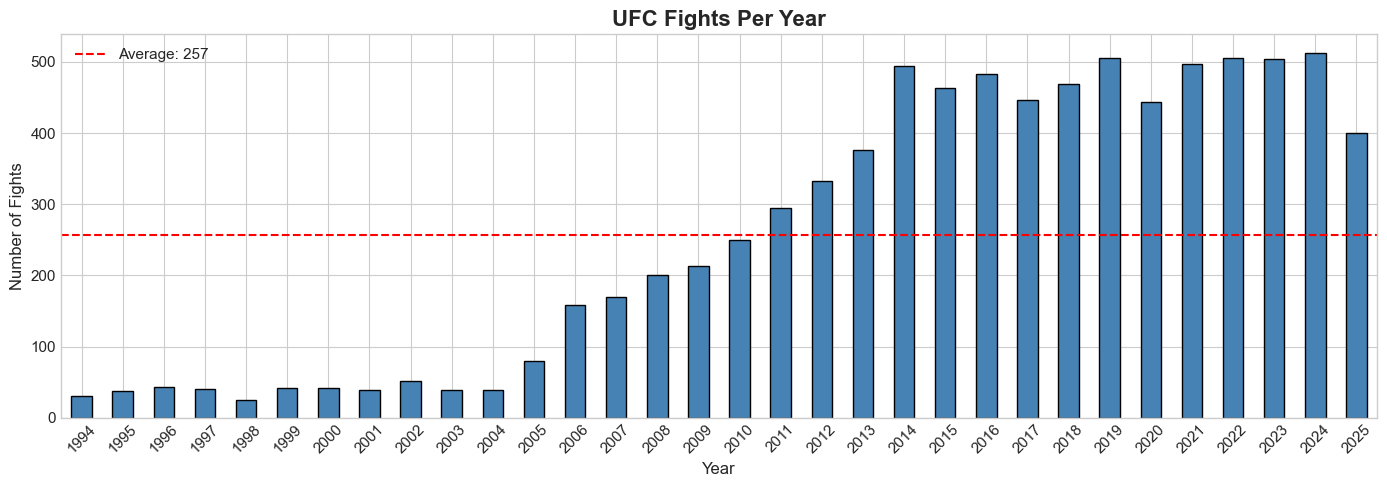


Average fights per year: 257
Peak year: 2024 (513 fights)


In [5]:
# Fights per year
df['year'] = df['event_date'].dt.year

fig, ax = plt.subplots(figsize=(14, 5))
fights_per_year = df.groupby('year').size()
fights_per_year.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('UFC Fights Per Year', fontsize=16, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Fights')
ax.axhline(y=fights_per_year.mean(), color='red', linestyle='--', label=f'Average: {fights_per_year.mean():.0f}')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nAverage fights per year: {fights_per_year.mean():.0f}")
print(f"Peak year: {fights_per_year.idxmax()} ({fights_per_year.max()} fights)")

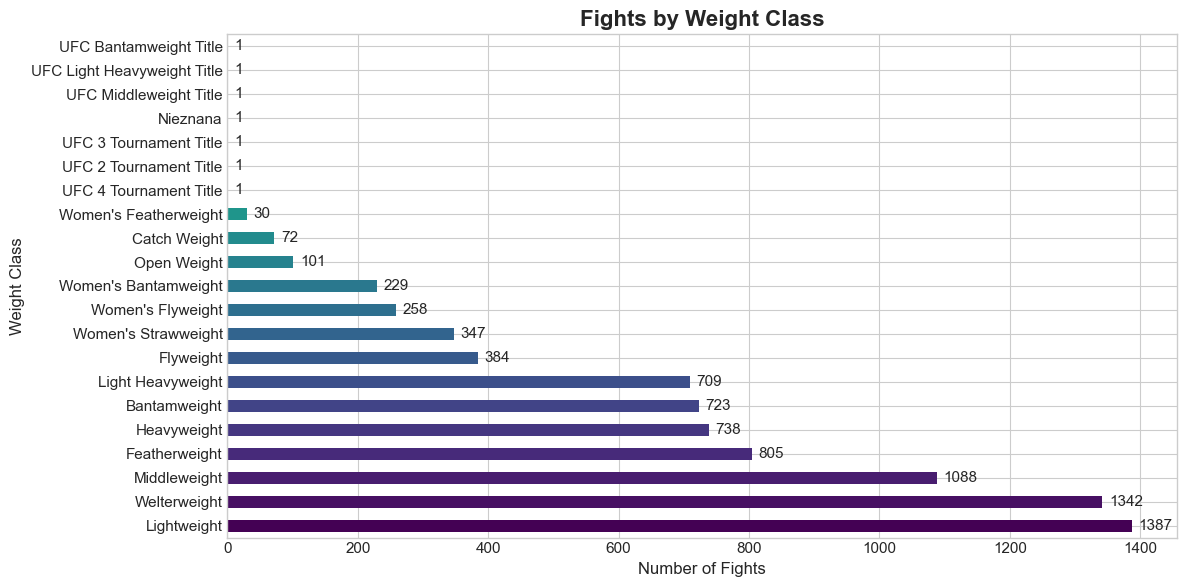

In [6]:
# Weight class distribution
fig, ax = plt.subplots(figsize=(12, 6))
weight_counts = df['weight_class'].value_counts()
colors = plt.cm.viridis(np.linspace(0, 0.8, len(weight_counts)))
weight_counts.plot(kind='barh', ax=ax, color=colors)
ax.set_title('Fights by Weight Class', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Fights')
ax.set_ylabel('Weight Class')

# Add count labels
for i, v in enumerate(weight_counts):
    ax.text(v + 10, i, str(v), va='center')

plt.tight_layout()
plt.show()

In [7]:
# Missing values analysis
print("\n" + "=" * 60)
print("MISSING VALUES (Key Columns)")
print("=" * 60)

key_cols = ['f_1_fighter_height_cm', 'f_1_fighter_reach_cm', 'f_1_age', 
            'f_1_fighter_stance', 'f_1_odds', 'f_2_odds']

for col in key_cols:
    if col in df.columns:
        missing = df[col].isna().sum()
        pct = missing / len(df) * 100
        print(f"{col}: {missing:,} missing ({pct:.1f}%)")


MISSING VALUES (Key Columns)
f_1_fighter_height_cm: 13 missing (0.2%)
f_1_fighter_reach_cm: 419 missing (5.1%)
f_1_age: 78 missing (0.9%)
f_1_fighter_stance: 31 missing (0.4%)
f_1_odds: 1,910 missing (23.2%)
f_2_odds: 1,909 missing (23.2%)


---
## 2. Target Variable Analysis

TARGET VARIABLE: Who Wins?

Fighter 1 wins: 5,318 (64.6%)
Fighter 2 wins: 2,912 (35.4%)


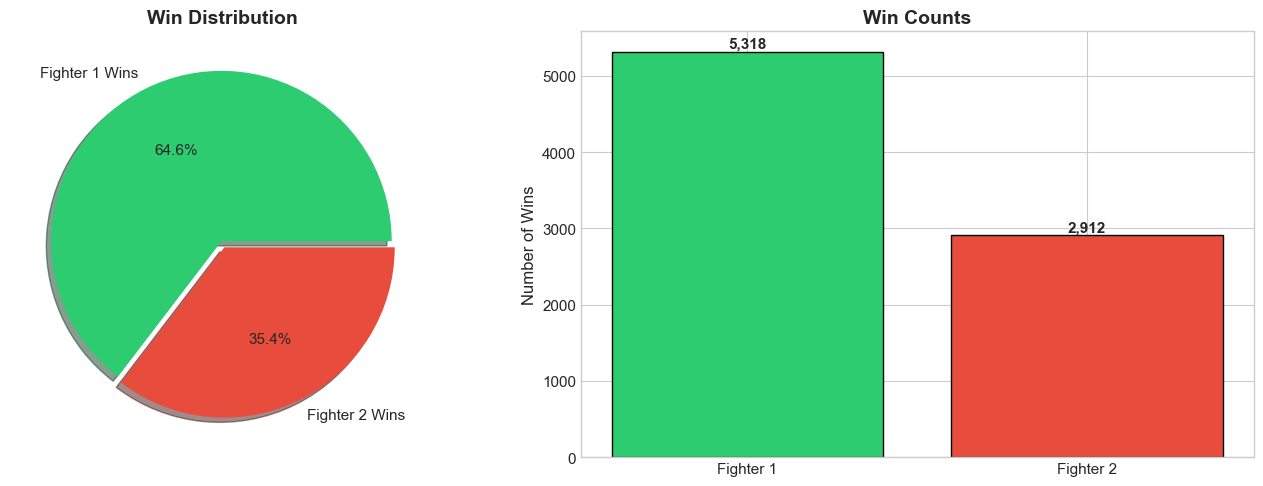


⚠️ Note: Fighter 1 wins 64.6% - this is class imbalance we need to handle in modeling.


In [8]:
# Target distribution
print("=" * 60)
print("TARGET VARIABLE: Who Wins?")
print("=" * 60)

target_counts = df['target'].value_counts()
print(f"\nFighter 1 wins: {target_counts[1]:,} ({target_counts[1]/len(df)*100:.1f}%)")
print(f"Fighter 2 wins: {target_counts[0]:,} ({target_counts[0]/len(df)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
axes[0].pie([target_counts[1], target_counts[0]], 
            labels=['Fighter 1 Wins', 'Fighter 2 Wins'],
            autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c'],
            explode=(0.02, 0.02),
            shadow=True)
axes[0].set_title('Win Distribution', fontsize=14, fontweight='bold')

# Bar chart
axes[1].bar(['Fighter 1', 'Fighter 2'], [target_counts[1], target_counts[0]], 
            color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[1].set_title('Win Counts', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Wins')
for i, v in enumerate([target_counts[1], target_counts[0]]):
    axes[1].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ Note: Fighter 1 wins 64.6% - this is class imbalance we need to handle in modeling.")


HOW FIGHTS END
result_type
Decision      3848
KO/TKO        2733
Submission    1626
Other           23
Name: count, dtype: int64


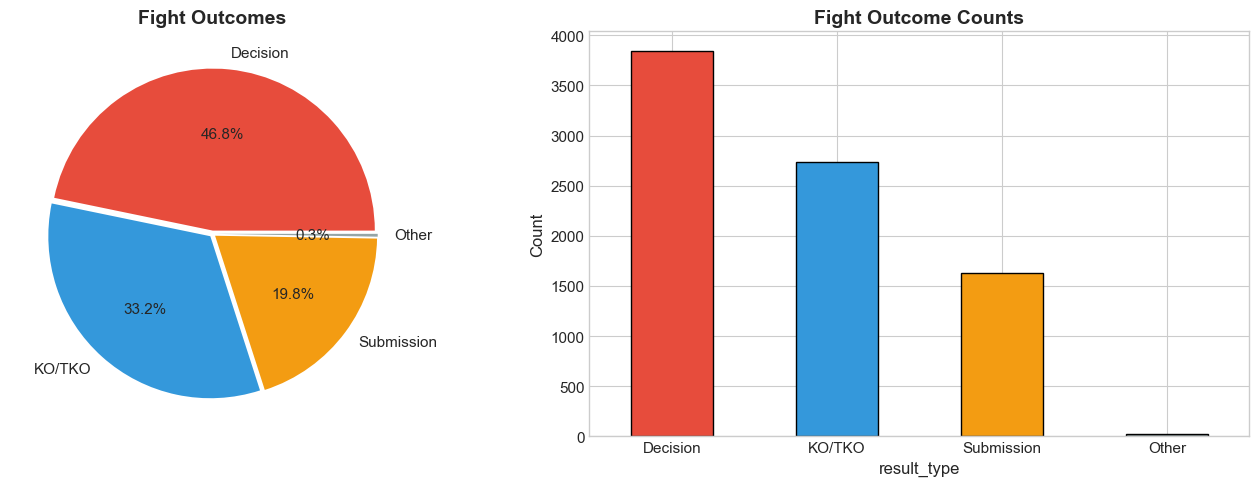

In [9]:
# Result types (how fights end)
print("\n" + "=" * 60)
print("HOW FIGHTS END")
print("=" * 60)

result_counts = df['result_type'].value_counts()
print(result_counts)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#e74c3c', '#3498db', '#f39c12', '#95a5a6']
axes[0].pie(result_counts.values, 
            labels=result_counts.index,
            autopct='%1.1f%%',
            colors=colors,
            explode=(0.02, 0.02, 0.02, 0.02))
axes[0].set_title('Fight Outcomes', fontsize=14, fontweight='bold')

# Bar chart
result_counts.plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title('Fight Outcome Counts', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

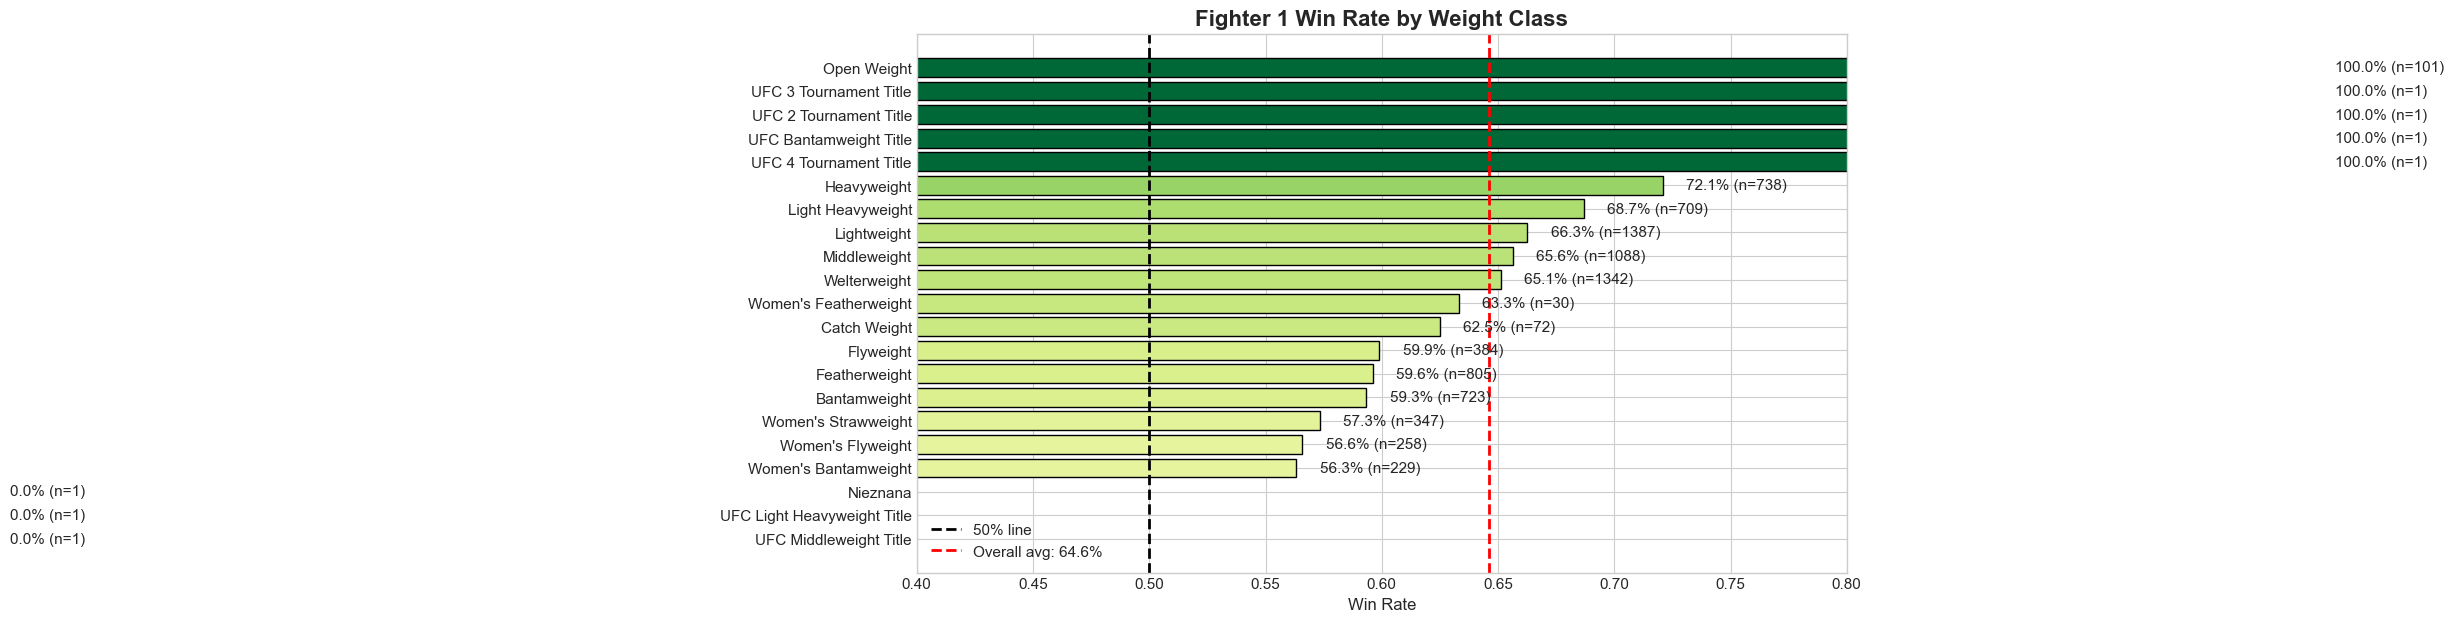

In [10]:
# Win rate by weight class
win_by_weight = df.groupby('weight_class')['target'].agg(['mean', 'count']).sort_values('mean', ascending=True)
win_by_weight.columns = ['F1_Win_Rate', 'Fights']

fig, ax = plt.subplots(figsize=(12, 7))
colors = plt.cm.RdYlGn(win_by_weight['F1_Win_Rate'])
bars = ax.barh(win_by_weight.index, win_by_weight['F1_Win_Rate'], color=colors, edgecolor='black')
ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='50% line')
ax.axvline(x=df['target'].mean(), color='red', linestyle='--', linewidth=2, label=f'Overall avg: {df["target"].mean():.1%}')
ax.set_title('Fighter 1 Win Rate by Weight Class', fontsize=16, fontweight='bold')
ax.set_xlabel('Win Rate')
ax.set_xlim(0.4, 0.8)
ax.legend()

# Add percentages
for i, (idx, row) in enumerate(win_by_weight.iterrows()):
    ax.text(row['F1_Win_Rate'] + 0.01, i, f"{row['F1_Win_Rate']:.1%} (n={row['Fights']:.0f})", va='center')

plt.tight_layout()
plt.show()


TITLE FIGHTS VS REGULAR FIGHTS
         F1_Win_Rate  Fights  KO_Rate
Regular        0.639    7787    0.329
Title          0.765     443    0.379


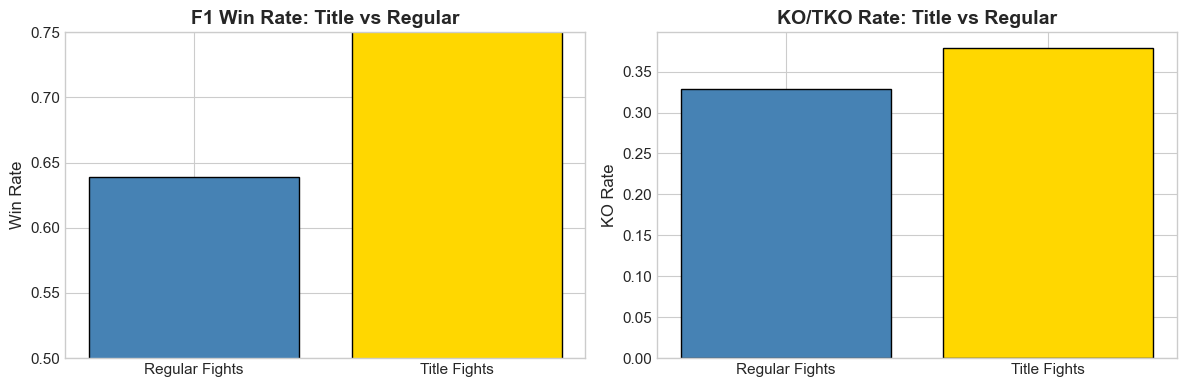

In [11]:
# Title fights vs regular fights
print("\n" + "=" * 60)
print("TITLE FIGHTS VS REGULAR FIGHTS")
print("=" * 60)

title_stats = df.groupby('title_fight').agg({
    'target': ['mean', 'count'],
    'result_type': lambda x: (x == 'KO/TKO').mean()
}).round(3)

title_stats.columns = ['F1_Win_Rate', 'Fights', 'KO_Rate']
title_stats.index = ['Regular', 'Title']
print(title_stats)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Win rate comparison
axes[0].bar(['Regular Fights', 'Title Fights'], title_stats['F1_Win_Rate'], 
            color=['steelblue', 'gold'], edgecolor='black')
axes[0].set_title('F1 Win Rate: Title vs Regular', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Win Rate')
axes[0].set_ylim(0.5, 0.75)

# KO rate comparison
axes[1].bar(['Regular Fights', 'Title Fights'], title_stats['KO_Rate'], 
            color=['steelblue', 'gold'], edgecolor='black')
axes[1].set_title('KO/TKO Rate: Title vs Regular', fontsize=14, fontweight='bold')
axes[1].set_ylabel('KO Rate')

plt.tight_layout()
plt.show()

---
## 3. Physical Attributes

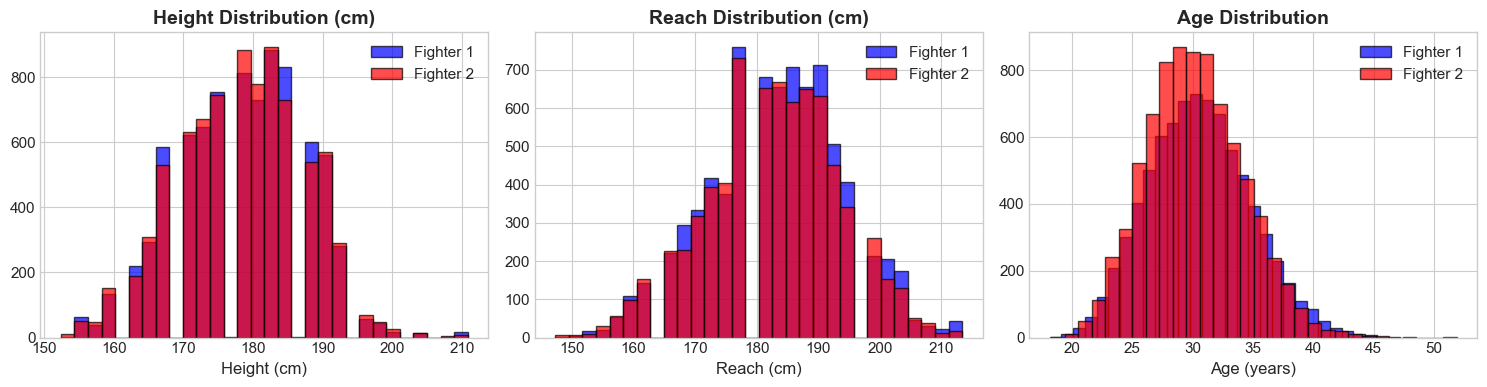

In [12]:
# Height distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Height
axes[0].hist(df['f_1_height'].dropna(), bins=30, alpha=0.7, label='Fighter 1', color='blue', edgecolor='black')
axes[0].hist(df['f_2_height'].dropna(), bins=30, alpha=0.7, label='Fighter 2', color='red', edgecolor='black')
axes[0].set_title('Height Distribution (cm)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Height (cm)')
axes[0].legend()

# Reach
axes[1].hist(df['f_1_reach'].dropna(), bins=30, alpha=0.7, label='Fighter 1', color='blue', edgecolor='black')
axes[1].hist(df['f_2_reach'].dropna(), bins=30, alpha=0.7, label='Fighter 2', color='red', edgecolor='black')
axes[1].set_title('Reach Distribution (cm)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Reach (cm)')
axes[1].legend()

# Age
axes[2].hist(df['f_1_age'].dropna(), bins=30, alpha=0.7, label='Fighter 1', color='blue', edgecolor='black')
axes[2].hist(df['f_2_age'].dropna(), bins=30, alpha=0.7, label='Fighter 2', color='red', edgecolor='black')
axes[2].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Age (years)')
axes[2].legend()

plt.tight_layout()
plt.show()

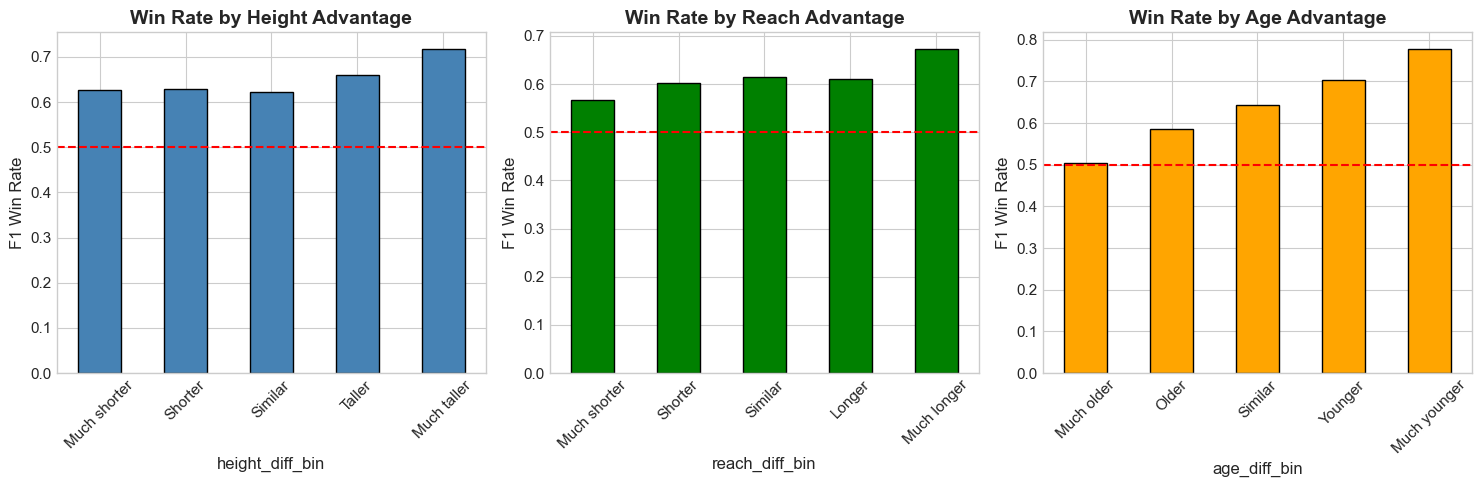


💡 Insight: Being taller, having longer reach, and being younger all correlate with winning.


In [13]:
# Physical advantages vs winning
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Height advantage
df['height_diff_bin'] = pd.cut(df['height_diff'], bins=[-50, -10, -2, 2, 10, 50], 
                                labels=['Much shorter', 'Shorter', 'Similar', 'Taller', 'Much taller'])
height_win = df.groupby('height_diff_bin')['target'].mean()
height_win.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].axhline(y=0.5, color='red', linestyle='--')
axes[0].set_title('Win Rate by Height Advantage', fontsize=14, fontweight='bold')
axes[0].set_ylabel('F1 Win Rate')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Reach advantage
df['reach_diff_bin'] = pd.cut(df['reach_diff'], bins=[-50, -10, -2, 2, 10, 50], 
                               labels=['Much shorter', 'Shorter', 'Similar', 'Longer', 'Much longer'])
reach_win = df.groupby('reach_diff_bin')['target'].mean()
reach_win.plot(kind='bar', ax=axes[1], color='green', edgecolor='black')
axes[1].axhline(y=0.5, color='red', linestyle='--')
axes[1].set_title('Win Rate by Reach Advantage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1 Win Rate')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# Age advantage
df['age_diff_bin'] = pd.cut(df['age_diff'], bins=[-20, -5, -2, 2, 5, 20], 
                             labels=['Much older', 'Older', 'Similar', 'Younger', 'Much younger'])
age_win = df.groupby('age_diff_bin')['target'].mean()
age_win.plot(kind='bar', ax=axes[2], color='orange', edgecolor='black')
axes[2].axhline(y=0.5, color='red', linestyle='--')
axes[2].set_title('Win Rate by Age Advantage', fontsize=14, fontweight='bold')
axes[2].set_ylabel('F1 Win Rate')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Being taller, having longer reach, and being younger all correlate with winning.")

In [14]:
# Stance analysis
print("\n" + "=" * 60)
print("STANCE ANALYSIS")
print("=" * 60)

stance_counts = df['f_1_fighter_stance'].value_counts()
print("\nStance distribution:")
print(stance_counts)

# Win rate by stance
stance_win = df.groupby('f_1_fighter_stance')['target'].agg(['mean', 'count'])
stance_win.columns = ['Win_Rate', 'Fights']
print("\nWin rate by stance:")
print(stance_win.sort_values('Win_Rate', ascending=False))

# Stance clash
clash_win = df.groupby('stance_clash')['target'].agg(['mean', 'count'])
clash_win.index = ['Same stance', 'Different stance']
print("\nStance clash effect:")
print(clash_win)


STANCE ANALYSIS

Stance distribution:
f_1_fighter_stance
Orthodox       6101
Southpaw       1629
Switch          452
Open Stance      15
Sideways          2
Name: count, dtype: int64

Win rate by stance:
                    Win_Rate  Fights
f_1_fighter_stance                  
Sideways               1.000       2
Open Stance            0.800      15
Southpaw               0.675    1629
Orthodox               0.639    6101
Switch                 0.631     452

Stance clash effect:
                  mean  count
Same stance      0.654   5033
Different stance 0.634   3197


---
## 4. Career Statistics

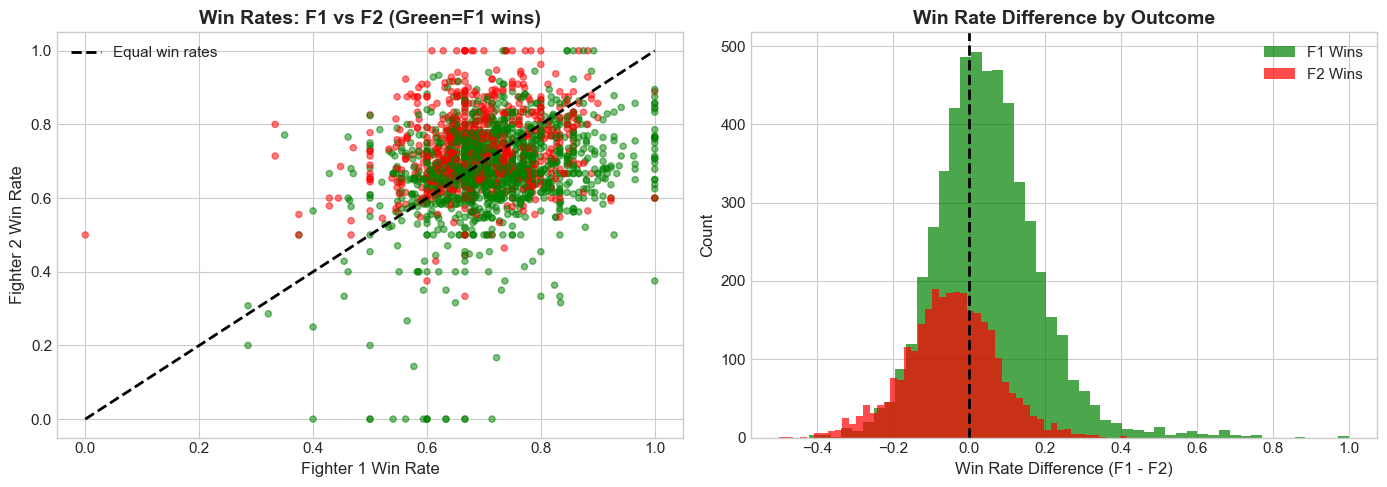


💡 Insight: Higher win rate difference strongly predicts the winner.


In [15]:
# Win rate difference vs outcome
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
sample = df.sample(min(2000, len(df)))  # Sample for visibility
colors = sample['target'].map({1: 'green', 0: 'red'})
axes[0].scatter(sample['f_1_win_rate'], sample['f_2_win_rate'], c=colors, alpha=0.5, s=20)
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Equal win rates')
axes[0].set_xlabel('Fighter 1 Win Rate')
axes[0].set_ylabel('Fighter 2 Win Rate')
axes[0].set_title('Win Rates: F1 vs F2 (Green=F1 wins)', fontsize=14, fontweight='bold')
axes[0].legend()

# Win rate difference histogram by outcome
df[df['target']==1]['win_rate_diff'].hist(ax=axes[1], bins=50, alpha=0.7, label='F1 Wins', color='green')
df[df['target']==0]['win_rate_diff'].hist(ax=axes[1], bins=50, alpha=0.7, label='F2 Wins', color='red')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Win Rate Difference (F1 - F2)')
axes[1].set_ylabel('Count')
axes[1].set_title('Win Rate Difference by Outcome', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n💡 Insight: Higher win rate difference strongly predicts the winner.")

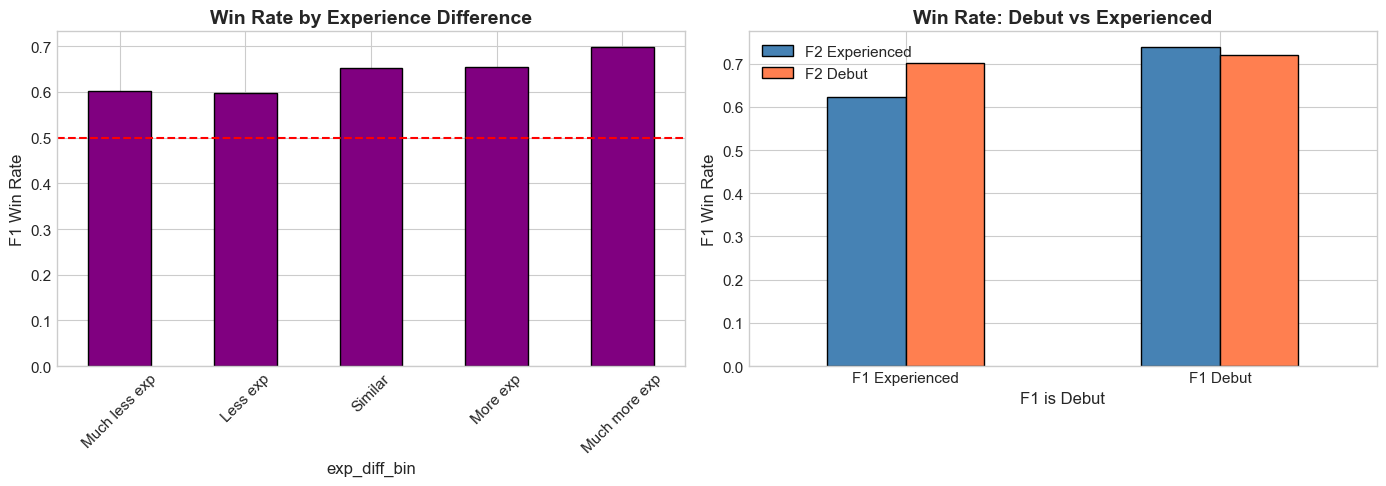


💡 Insight: Experience matters, but debut fighters can still win ~50% against other debutants.


In [16]:
# Experience analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Experience difference bins
df['exp_diff_bin'] = pd.cut(df['exp_diff'], bins=[-100, -10, -3, 3, 10, 100],
                            labels=['Much less exp', 'Less exp', 'Similar', 'More exp', 'Much more exp'])
exp_win = df.groupby('exp_diff_bin')['target'].mean()
exp_win.plot(kind='bar', ax=axes[0], color='purple', edgecolor='black')
axes[0].axhline(y=0.5, color='red', linestyle='--')
axes[0].set_title('Win Rate by Experience Difference', fontsize=14, fontweight='bold')
axes[0].set_ylabel('F1 Win Rate')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# UFC experience (debut effect)
debut_win = df.groupby(['f_1_is_debut', 'f_2_is_debut'])['target'].mean().unstack()
debut_win.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'], edgecolor='black')
axes[1].set_title('Win Rate: Debut vs Experienced', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1 Win Rate')
axes[1].set_xlabel('F1 is Debut')
axes[1].legend(['F2 Experienced', 'F2 Debut'])
axes[1].set_xticklabels(['F1 Experienced', 'F1 Debut'], rotation=0)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Experience matters, but debut fighters can still win ~50% against other debutants.")

---
## 5. Fighting Style Analysis

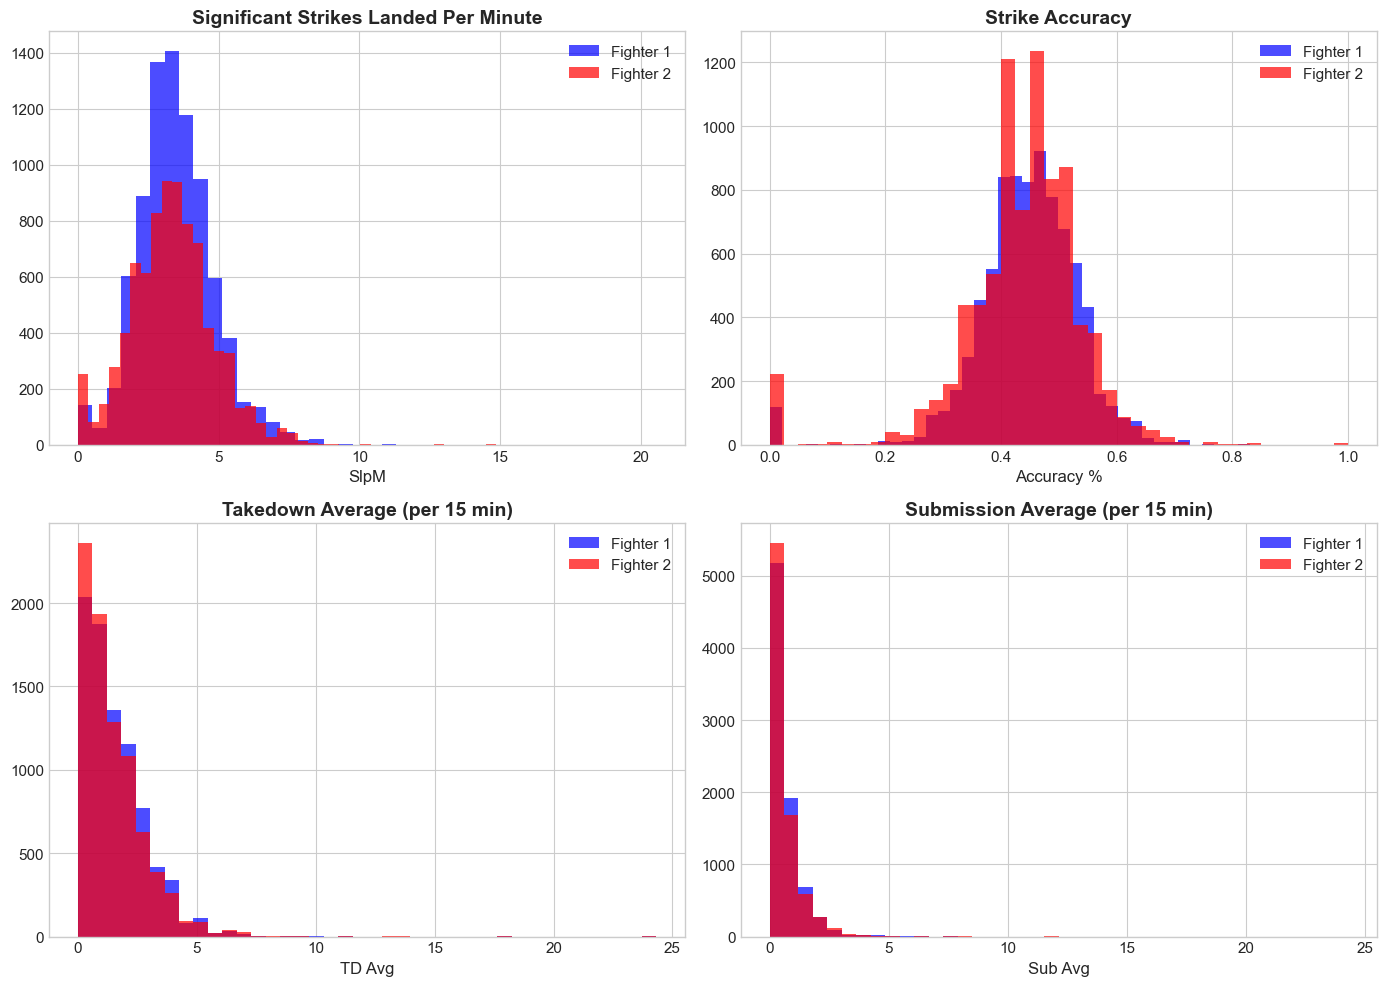

In [17]:
# Striking stats distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Strikes landed per minute
axes[0, 0].hist(df['f_1_slpm'].dropna(), bins=40, alpha=0.7, label='Fighter 1', color='blue')
axes[0, 0].hist(df['f_2_slpm'].dropna(), bins=40, alpha=0.7, label='Fighter 2', color='red')
axes[0, 0].set_title('Significant Strikes Landed Per Minute', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('SlpM')
axes[0, 0].legend()

# Strike accuracy
axes[0, 1].hist(df['f_1_str_acc'].dropna(), bins=40, alpha=0.7, label='Fighter 1', color='blue')
axes[0, 1].hist(df['f_2_str_acc'].dropna(), bins=40, alpha=0.7, label='Fighter 2', color='red')
axes[0, 1].set_title('Strike Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Accuracy %')
axes[0, 1].legend()

# Takedown average
axes[1, 0].hist(df['f_1_td_avg'].dropna(), bins=40, alpha=0.7, label='Fighter 1', color='blue')
axes[1, 0].hist(df['f_2_td_avg'].dropna(), bins=40, alpha=0.7, label='Fighter 2', color='red')
axes[1, 0].set_title('Takedown Average (per 15 min)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('TD Avg')
axes[1, 0].legend()

# Submission average
axes[1, 1].hist(df['f_1_sub_avg'].dropna(), bins=40, alpha=0.7, label='Fighter 1', color='blue')
axes[1, 1].hist(df['f_2_sub_avg'].dropna(), bins=40, alpha=0.7, label='Fighter 2', color='red')
axes[1, 1].set_title('Submission Average (per 15 min)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sub Avg')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

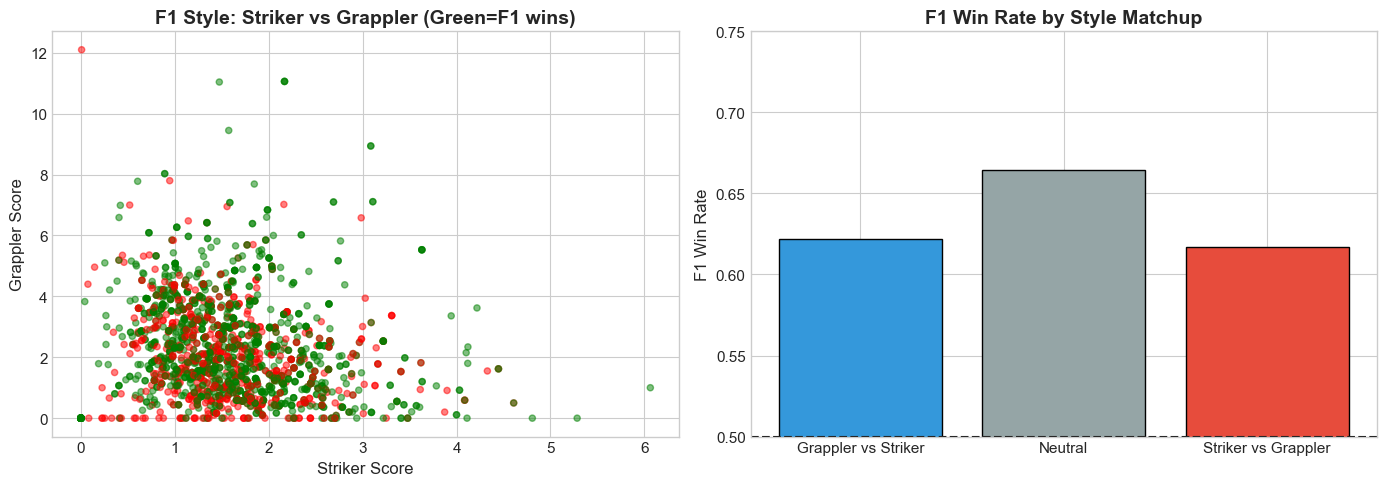


💡 Insight: Grappler vs Striker matchups show similar win rates - style alone isn't decisive.


In [18]:
# Striker vs Grappler analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: Striker score vs Grappler score
sample = df.sample(min(2000, len(df)))
colors = sample['target'].map({1: 'green', 0: 'red'})
axes[0].scatter(sample['f_1_striker_score'], sample['f_1_grappler_score'], c=colors, alpha=0.5, s=20)
axes[0].set_xlabel('Striker Score')
axes[0].set_ylabel('Grappler Score')
axes[0].set_title('F1 Style: Striker vs Grappler (Green=F1 wins)', fontsize=14, fontweight='bold')

# Style matchup win rates
style_matchup = df.groupby(['f_1_grappler_vs_f_2_striker', 'f_1_striker_vs_f_2_grappler'])['target'].mean().unstack()
style_labels = ['Neither', 'F1 Striker vs F2 Grappler']
ax2 = axes[1]

# Simplified style comparison
grappler_vs_striker = df[df['f_1_grappler_vs_f_2_striker']==1]['target'].mean()
striker_vs_grappler = df[df['f_1_striker_vs_f_2_grappler']==1]['target'].mean()
neutral = df[(df['f_1_grappler_vs_f_2_striker']==0) & (df['f_1_striker_vs_f_2_grappler']==0)]['target'].mean()

bars = ax2.bar(['Grappler vs Striker', 'Neutral', 'Striker vs Grappler'], 
               [grappler_vs_striker, neutral, striker_vs_grappler],
               color=['#3498db', '#95a5a6', '#e74c3c'], edgecolor='black')
ax2.axhline(y=0.5, color='black', linestyle='--')
ax2.set_title('F1 Win Rate by Style Matchup', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1 Win Rate')
ax2.set_ylim(0.5, 0.75)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Grappler vs Striker matchups show similar win rates - style alone isn't decisive.")

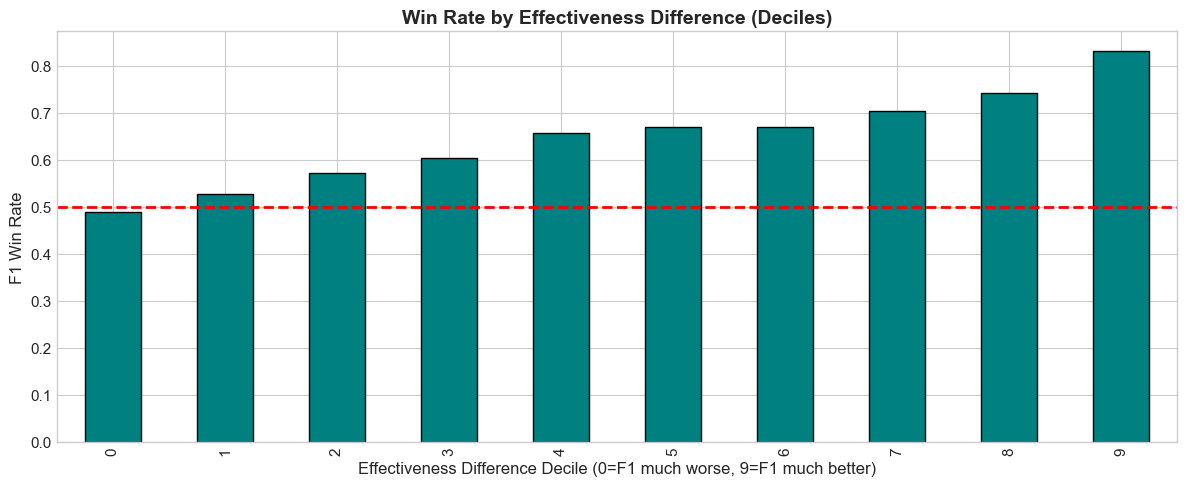


💡 Insight: Clear linear relationship - higher effectiveness difference → higher win rate.


In [19]:
# Effectiveness score vs winning
fig, ax = plt.subplots(figsize=(12, 5))

df['eff_diff_bin'] = pd.qcut(df['effectiveness_diff'], q=10, labels=False, duplicates='drop')
eff_win = df.groupby('eff_diff_bin')['target'].mean()

eff_win.plot(kind='bar', ax=ax, color='teal', edgecolor='black')
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2)
ax.set_title('Win Rate by Effectiveness Difference (Deciles)', fontsize=14, fontweight='bold')
ax.set_xlabel('Effectiveness Difference Decile (0=F1 much worse, 9=F1 much better)')
ax.set_ylabel('F1 Win Rate')

plt.tight_layout()
plt.show()

print("\n💡 Insight: Clear linear relationship - higher effectiveness difference → higher win rate.")

---
## 6. Momentum & Streaks

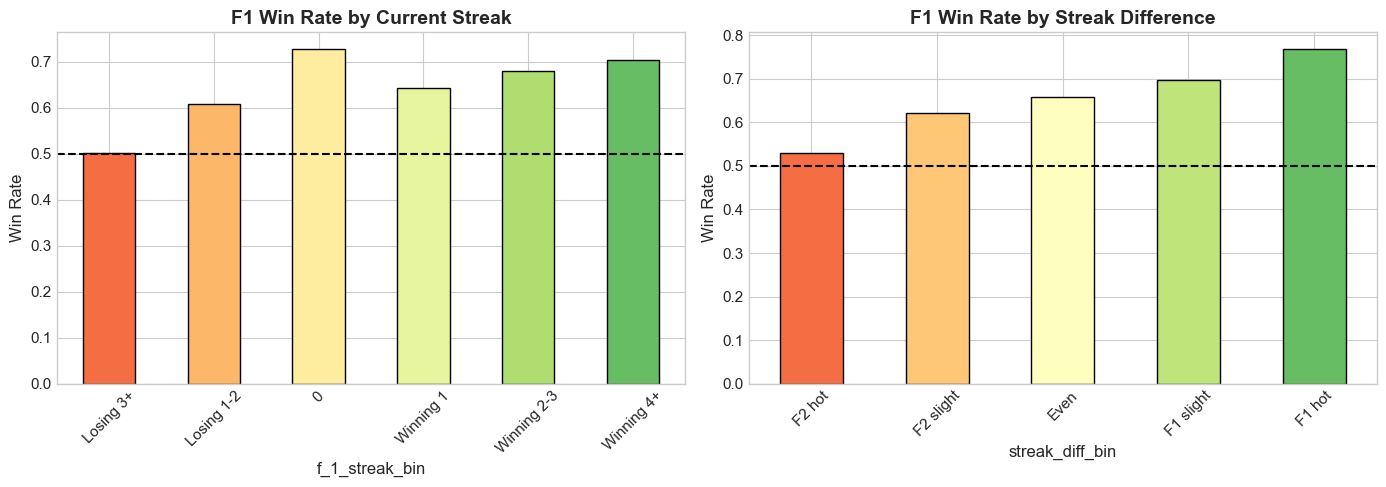


💡 Insight: Momentum matters! Fighters on win streaks have higher win rates.


In [20]:
# Win/Loss streak analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 streak vs win rate
streak_bins = [-10, -3, -1, 0, 1, 3, 10]
streak_labels = ['Losing 3+', 'Losing 1-2', '0', 'Winning 1', 'Winning 2-3', 'Winning 4+']
df['f_1_streak_bin'] = pd.cut(df['f_1_streak'], bins=streak_bins, labels=streak_labels)
streak_win = df.groupby('f_1_streak_bin')['target'].mean()

colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(streak_win)))
streak_win.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].axhline(y=0.5, color='black', linestyle='--')
axes[0].set_title('F1 Win Rate by Current Streak', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Win Rate')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Streak difference
df['streak_diff_bin'] = pd.cut(df['streak_diff'], bins=[-15, -3, -1, 1, 3, 15],
                               labels=['F2 hot', 'F2 slight', 'Even', 'F1 slight', 'F1 hot'])
streak_diff_win = df.groupby('streak_diff_bin')['target'].mean()

colors2 = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(streak_diff_win)))
streak_diff_win.plot(kind='bar', ax=axes[1], color=colors2, edgecolor='black')
axes[1].axhline(y=0.5, color='black', linestyle='--')
axes[1].set_title('F1 Win Rate by Streak Difference', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Win Rate')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Momentum matters! Fighters on win streaks have higher win rates.")

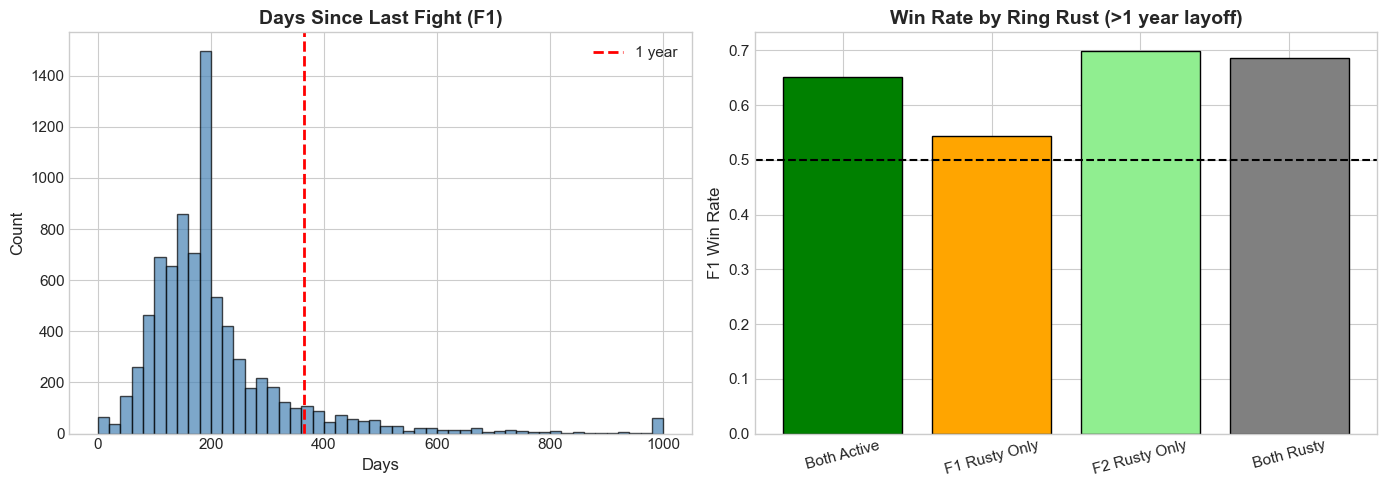


💡 Insight: Ring rust (>1 year layoff) slightly hurts fighters, but not dramatically.


In [21]:
# Ring rust analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Days since last fight distribution
axes[0].hist(df['f_1_days_since_fight'].clip(upper=1000), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(x=365, color='red', linestyle='--', linewidth=2, label='1 year')
axes[0].set_title('Days Since Last Fight (F1)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Count')
axes[0].legend()

# Ring rust effect
rust_win = df.groupby(['f_1_ring_rust', 'f_2_ring_rust'])['target'].mean()
rust_labels = ['Both Active', 'F1 Rusty Only', 'F2 Rusty Only', 'Both Rusty']
rust_values = [
    df[(df['f_1_ring_rust']==0) & (df['f_2_ring_rust']==0)]['target'].mean(),
    df[(df['f_1_ring_rust']==1) & (df['f_2_ring_rust']==0)]['target'].mean(),
    df[(df['f_1_ring_rust']==0) & (df['f_2_ring_rust']==1)]['target'].mean(),
    df[(df['f_1_ring_rust']==1) & (df['f_2_ring_rust']==1)]['target'].mean(),
]

colors = ['green', 'orange', 'lightgreen', 'gray']
axes[1].bar(rust_labels, rust_values, color=colors, edgecolor='black')
axes[1].axhline(y=0.5, color='black', linestyle='--')
axes[1].set_title('Win Rate by Ring Rust (>1 year layoff)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1 Win Rate')
axes[1].set_xticklabels(rust_labels, rotation=15)

plt.tight_layout()
plt.show()

print("\n💡 Insight: Ring rust (>1 year layoff) slightly hurts fighters, but not dramatically.")

---
## 7. Betting Odds Analysis

Fights with betting odds: 6,320 (76.8%)


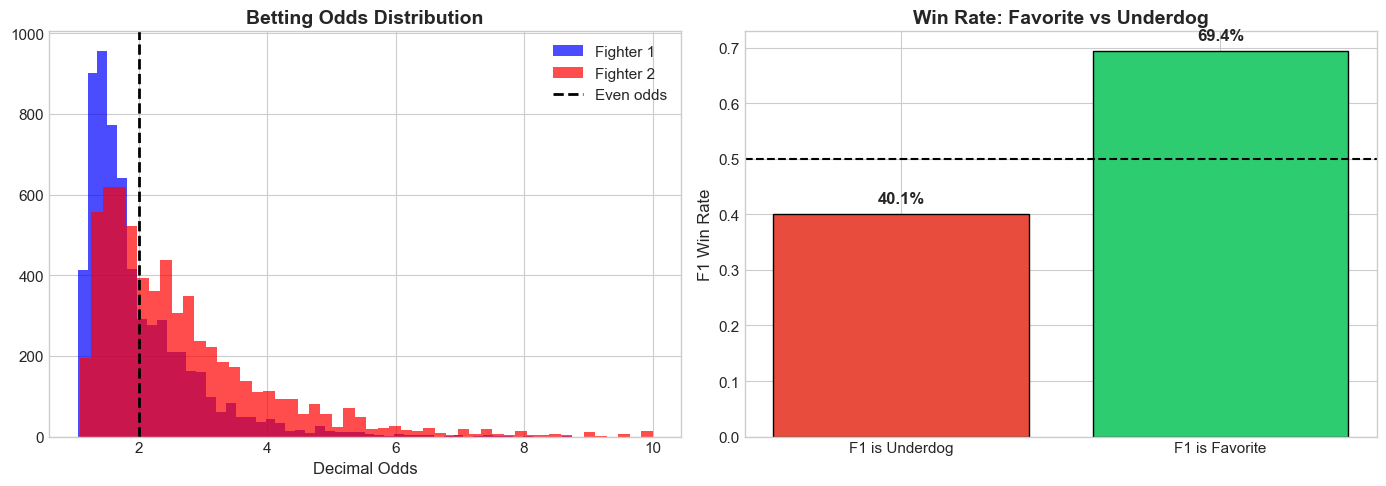


💡 Key Insight:
   - Favorites win 69.4% of the time
   - Underdogs win 30.6% of the time
   - Betting odds are HIGHLY predictive!


In [22]:
# Filter to fights with odds
df_odds = df[df['f_1_odds'].notna()].copy()
print(f"Fights with betting odds: {len(df_odds):,} ({len(df_odds)/len(df)*100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Odds distribution
axes[0].hist(df_odds['f_1_odds'].clip(upper=10), bins=50, alpha=0.7, label='Fighter 1', color='blue')
axes[0].hist(df_odds['f_2_odds'].clip(upper=10), bins=50, alpha=0.7, label='Fighter 2', color='red')
axes[0].axvline(x=2.0, color='black', linestyle='--', linewidth=2, label='Even odds')
axes[0].set_title('Betting Odds Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Decimal Odds')
axes[0].legend()

# Favorite vs Underdog win rate
fav_win = df_odds.groupby('f_1_is_favorite')['target'].mean()
axes[1].bar(['F1 is Underdog', 'F1 is Favorite'], [fav_win[0], fav_win[1]], 
            color=['#e74c3c', '#2ecc71'], edgecolor='black')
axes[1].axhline(y=0.5, color='black', linestyle='--')
axes[1].set_title('Win Rate: Favorite vs Underdog', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1 Win Rate')

for i, v in enumerate([fav_win[0], fav_win[1]]):
    axes[1].text(i, v + 0.02, f'{v:.1%}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\n💡 Key Insight:")
print(f"   - Favorites win {fav_win[1]:.1%} of the time")
print(f"   - Underdogs win {1-fav_win[1]:.1%} of the time")
print(f"   - Betting odds are HIGHLY predictive!")

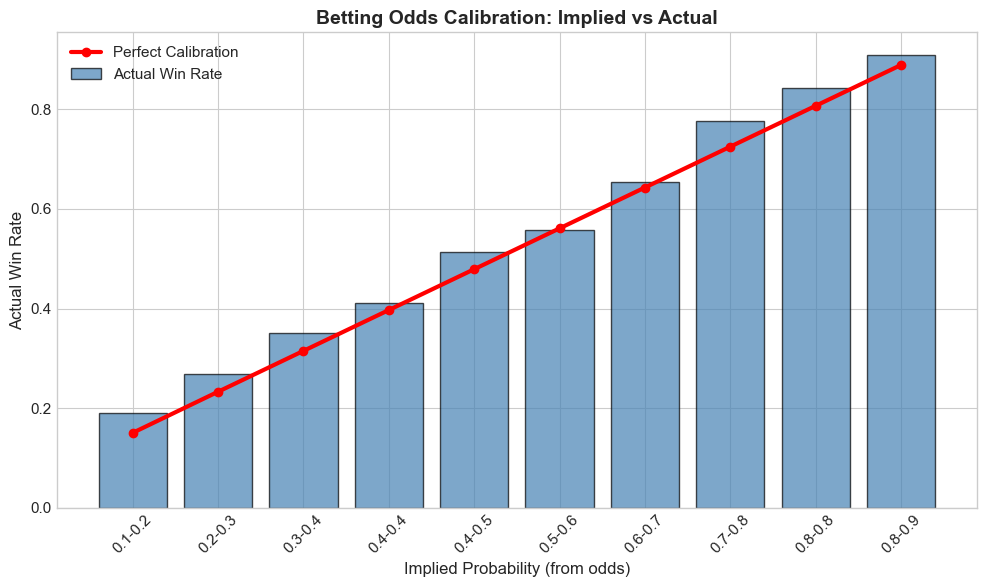


💡 Insight: Betting odds are well-calibrated - implied probability closely matches actual win rate.
   This means odds capture most of the predictable information about fight outcomes.


In [23]:
# Implied probability vs actual win rate
df_odds['implied_prob_bin'] = pd.cut(df_odds['f_1_implied_prob_norm'], bins=10)
prob_calibration = df_odds.groupby('implied_prob_bin')['target'].mean()

fig, ax = plt.subplots(figsize=(10, 6))

# Plot calibration
x = np.arange(len(prob_calibration))
ax.bar(x, prob_calibration.values, color='steelblue', edgecolor='black', alpha=0.7, label='Actual Win Rate')

# Perfect calibration line
bin_centers = [interval.mid for interval in prob_calibration.index]
ax.plot(x, bin_centers, 'r-', linewidth=3, marker='o', label='Perfect Calibration')

ax.set_xticks(x)
ax.set_xticklabels([f'{interval.left:.1f}-{interval.right:.1f}' for interval in prob_calibration.index], rotation=45)
ax.set_xlabel('Implied Probability (from odds)')
ax.set_ylabel('Actual Win Rate')
ax.set_title('Betting Odds Calibration: Implied vs Actual', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

print("\n💡 Insight: Betting odds are well-calibrated - implied probability closely matches actual win rate.")
print("   This means odds capture most of the predictable information about fight outcomes.")

In [24]:
# Heavy favorites and underdogs
print("\n" + "=" * 60)
print("HEAVY FAVORITES & UNDERDOGS")
print("=" * 60)

heavy_fav = df_odds[df_odds['f_1_heavy_favorite']==1]['target'].mean()
heavy_dog = df_odds[df_odds['f_1_heavy_underdog']==1]['target'].mean()
normal = df_odds[(df_odds['f_1_heavy_favorite']==0) & (df_odds['f_1_heavy_underdog']==0)]['target'].mean()

print(f"\nHeavy favorite (odds < 1.4): wins {heavy_fav:.1%}")
print(f"Normal range: wins {normal:.1%}")
print(f"Heavy underdog (odds > 3.0): wins {heavy_dog:.1%}")

# Upset analysis
upsets = df_odds[(df_odds['f_1_is_favorite']==1) & (df_odds['target']==0)]
print(f"\nUpsets (favorite lost): {len(upsets):,} ({len(upsets)/len(df_odds[df_odds['f_1_is_favorite']==1])*100:.1f}%)")


HEAVY FAVORITES & UNDERDOGS

Heavy favorite (odds < 1.4): wins 81.6%
Normal range: wins 53.9%
Heavy underdog (odds > 3.0): wins 28.5%

Upsets (favorite lost): 1,186 (30.6%)


---
## 8. Feature Correlations

In [25]:
# Correlation with target
print("=" * 60)
print("TOP FEATURES CORRELATED WITH WINNING")
print("=" * 60)

# Get numeric columns from model-ready data
correlations = df_model.corr()['target'].drop('target').sort_values(key=abs, ascending=False)

print("\nTop 20 features by absolute correlation with target:")
print(correlations.head(20))

TOP FEATURES CORRELATED WITH WINNING

Top 20 features by absolute correlation with target:
record_score_diff        0.331
win_rate_diff            0.330
loss_rate_diff           0.328
str_differential_diff    0.277
f_2_win_rate            -0.262
f_2_record_score        -0.262
f_2_loss_rate            0.258
f_2_striker_score       -0.254
f_2_slpm                -0.247
striking_battle          0.245
f_2_ko_power            -0.231
f_2_str_differential    -0.231
slpm_diff                0.211
f_2_td_def              -0.206
str_acc_diff             0.190
age_diff                 0.187
ko_power_diff            0.186
f_2_str_acc             -0.184
td_def_diff              0.183
f_1_sapm                -0.180
Name: target, dtype: float64


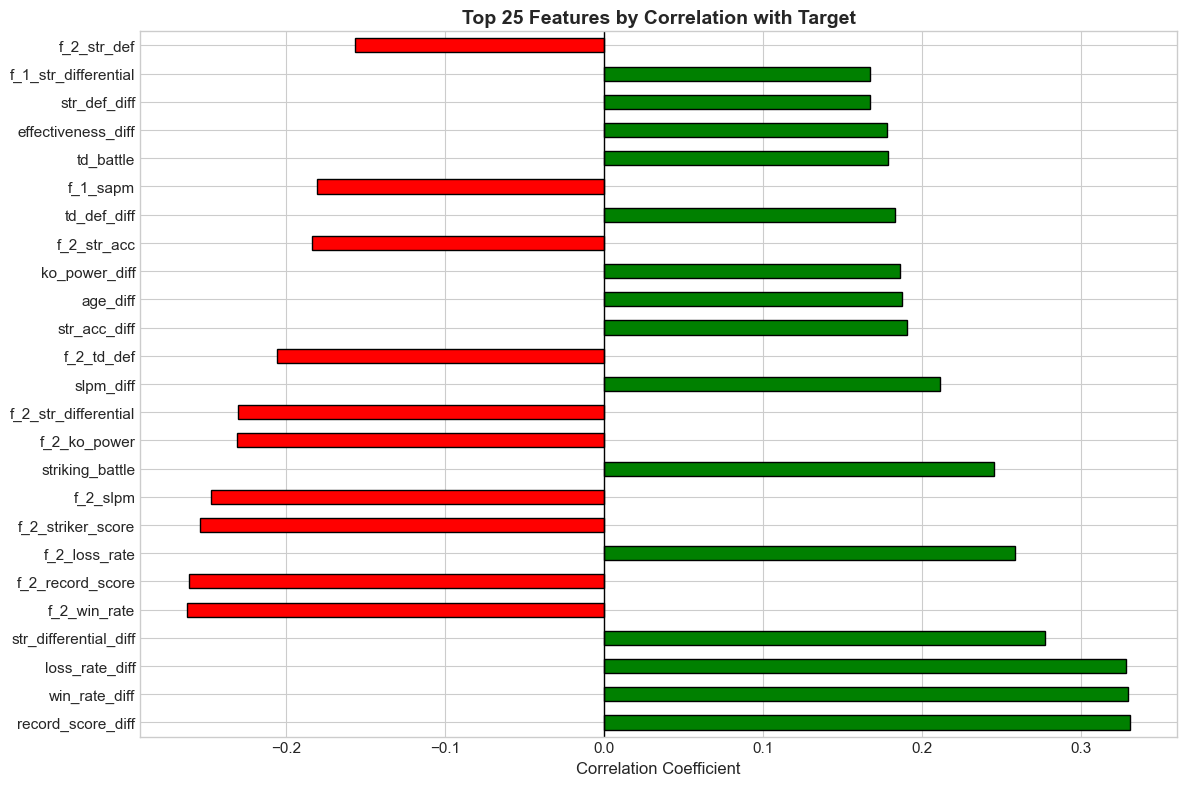


💡 Interpretation:
   Green (positive) = Higher value → F1 more likely to win
   Red (negative) = Higher value → F2 more likely to win


In [26]:
# Correlation bar chart
fig, ax = plt.subplots(figsize=(12, 8))

top_corr = correlations.head(25)
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
top_corr.plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.axvline(x=0, color='black', linewidth=1)
ax.set_title('Top 25 Features by Correlation with Target', fontsize=14, fontweight='bold')
ax.set_xlabel('Correlation Coefficient')

plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   Green (positive) = Higher value → F1 more likely to win")
print("   Red (negative) = Higher value → F2 more likely to win")

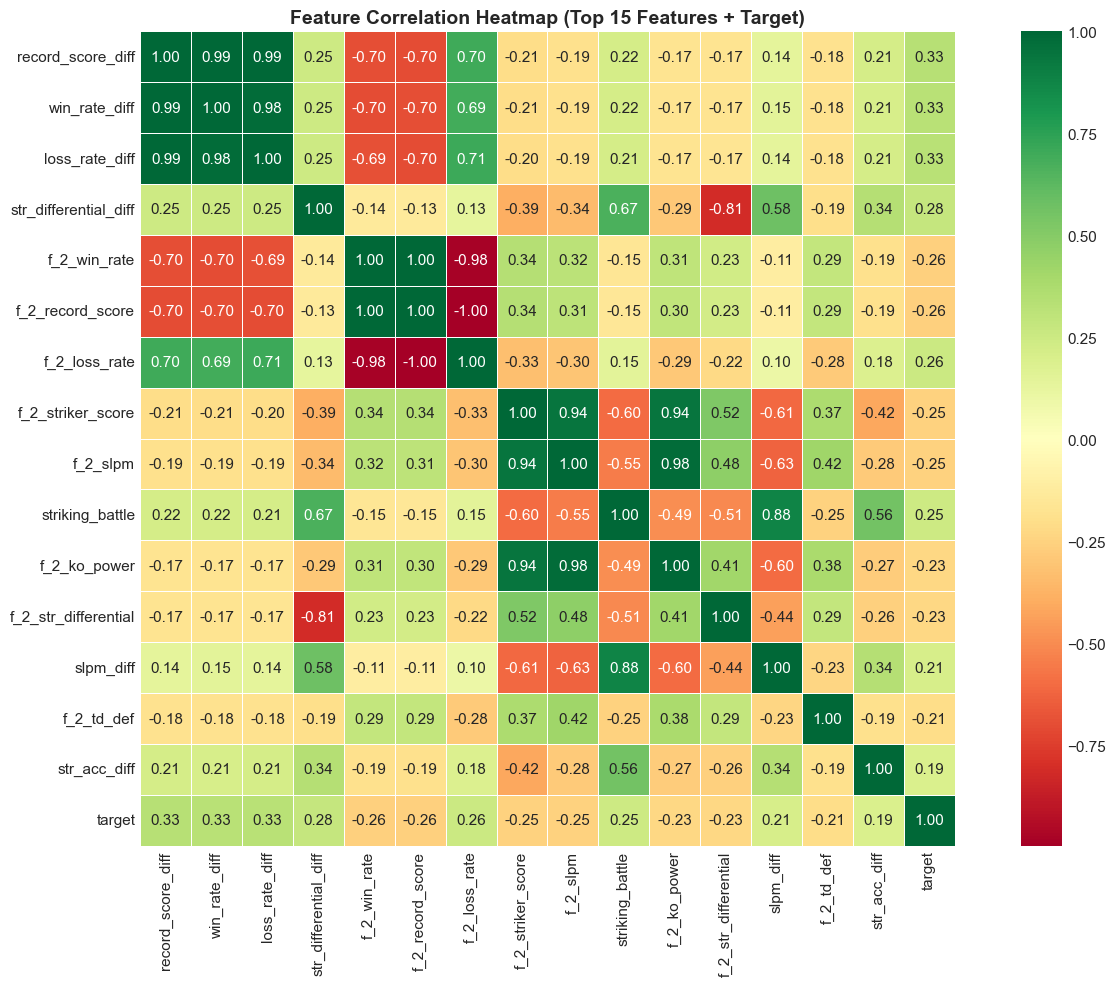


💡 Insight: Some features are highly correlated with each other (multicollinearity).
   Tree-based models (XGBoost) handle this well, but we may want to remove redundant features.


In [27]:
# Feature correlation heatmap (top features only)
top_features = correlations.head(15).index.tolist() + ['target']
corr_matrix = df_model[top_features].corr()

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Feature Correlation Heatmap (Top 15 Features + Target)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Insight: Some features are highly correlated with each other (multicollinearity).")
print("   Tree-based models (XGBoost) handle this well, but we may want to remove redundant features.")

In [28]:
# Multicollinearity check - find highly correlated feature pairs
print("\n" + "=" * 60)
print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)")
print("=" * 60)

full_corr = df_model.drop('target', axis=1).corr()

# Find pairs with high correlation
high_corr_pairs = []
for i in range(len(full_corr.columns)):
    for j in range(i+1, len(full_corr.columns)):
        if abs(full_corr.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                full_corr.columns[i],
                full_corr.columns[j],
                full_corr.iloc[i, j]
            ))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
print(f"\nFound {len(high_corr_df)} highly correlated pairs:")
print(high_corr_df.head(15))


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.8)

Found 33 highly correlated pairs:
          Feature 1              Feature 2  Correlation
3      f_2_win_rate       f_2_record_score        0.996
7     f_2_loss_rate       f_2_record_score       -0.995
1      f_1_win_rate       f_1_record_score        0.995
6     f_1_loss_rate       f_1_record_score       -0.995
5     win_rate_diff      record_score_diff        0.995
8    loss_rate_diff      record_score_diff        0.994
28  sub_threat_diff  finish_potential_diff        0.989
26   f_1_sub_threat   f_1_finish_potential        0.984
12         f_2_slpm           f_2_ko_power        0.984
10         f_1_slpm           f_1_ko_power        0.982
2      f_2_win_rate          f_2_loss_rate       -0.982
27   f_2_sub_threat   f_2_finish_potential        0.981
0      f_1_win_rate          f_1_loss_rate       -0.981
4     win_rate_diff         loss_rate_diff        0.978
13        slpm_diff          ko_power_diff        0.977


---
## 9. Key Insights Summary

In [29]:
print("="*70)
print("                    EDA KEY INSIGHTS SUMMARY")
print("="*70)

print("""
📊 DATASET:
   • 8,230 UFC fights from 1994-2025
   • 2,615 unique fighters
   • 21 weight classes
   • 110 engineered features

🎯 TARGET VARIABLE:
   • Fighter 1 wins 64.6% of fights (class imbalance)
   • 46.8% end by Decision, 33.2% by KO/TKO, 19.8% by Submission

💪 PHYSICAL ATTRIBUTES:
   • Height advantage slightly increases win probability
   • Reach advantage slightly increases win probability  
   • Being younger correlates with winning
   • Prime age (27-32) fighters perform best

📈 CAREER STATISTICS:
   • Win rate difference is HIGHLY predictive
   • Experience matters but not as much as win rate
   • Debut fighters have ~50% win rate vs other debutants

🥋 FIGHTING STYLE:
   • Effectiveness score (striking + grappling combined) predicts well
   • Pure striker vs grappler matchups don't favor either style
   • Strike differential (landed - absorbed) is important

🔥 MOMENTUM:
   • Win streaks increase win probability
   • Lose streaks decrease win probability
   • Ring rust (>1 year layoff) has mild negative effect

💰 BETTING ODDS:
   • Favorites win ~67% of fights
   • Odds are well-calibrated (implied prob ≈ actual win rate)
   • Heavy favorites (odds < 1.4) win ~78%
   • Odds are the SINGLE MOST PREDICTIVE feature

⚠️ MODELING CONSIDERATIONS:
   • Class imbalance (65/35) - use class weights or oversampling
   • High multicollinearity - tree models handle this well
   • Betting odds may dominate other features
   • Test models WITH and WITHOUT odds to understand true feature value
""")

print("="*70)
print("                       ✓ EDA Complete!")
print("="*70)

                    EDA KEY INSIGHTS SUMMARY

📊 DATASET:
   • 8,230 UFC fights from 1994-2025
   • 2,615 unique fighters
   • 21 weight classes
   • 110 engineered features

🎯 TARGET VARIABLE:
   • Fighter 1 wins 64.6% of fights (class imbalance)
   • 46.8% end by Decision, 33.2% by KO/TKO, 19.8% by Submission

💪 PHYSICAL ATTRIBUTES:
   • Height advantage slightly increases win probability
   • Reach advantage slightly increases win probability  
   • Being younger correlates with winning
   • Prime age (27-32) fighters perform best

📈 CAREER STATISTICS:
   • Win rate difference is HIGHLY predictive
   • Experience matters but not as much as win rate
   • Debut fighters have ~50% win rate vs other debutants

🥋 FIGHTING STYLE:
   • Effectiveness score (striking + grappling combined) predicts well
   • Pure striker vs grappler matchups don't favor either style
   • Strike differential (landed - absorbed) is important

🔥 MOMENTUM:
   • Win streaks increase win probability
   • Lose streak

In [30]:
# Save key statistics for reference
summary_stats = {
    'total_fights': len(df),
    'unique_fighters': len(set(df['f_1_name'].unique()) | set(df['f_2_name'].unique())),
    'date_range': f"{df['event_date'].min().date()} to {df['event_date'].max().date()}",
    'f1_win_rate': df['target'].mean(),
    'ko_rate': (df['result_type'] == 'KO/TKO').mean(),
    'decision_rate': (df['result_type'] == 'Decision').mean(),
    'submission_rate': (df['result_type'] == 'Submission').mean(),
    'title_fights': df['title_fight'].sum(),
    'fights_with_odds': df['f_1_odds'].notna().sum(),
    'favorite_win_rate': df_odds[df_odds['f_1_is_favorite']==1]['target'].mean() if len(df_odds) > 0 else None,
    'top_predictive_features': correlations.head(10).index.tolist(),
}

# Save to file
import json
with open(DATA_PATH / 'eda_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)

print("\n✓ EDA summary saved to ../data/processed/eda_summary.json")


✓ EDA summary saved to ../data/processed/eda_summary.json
